In [49]:
%load_ext autoreload
%autoreload

# !nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

import matplotlib.pyplot as plt
%matplotlib notebook
import MEAutility as mu

import json
import numpy
import time
import numpy as np
import LFPy
import neuroplotlib as nplt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define extracellular electrodes

In [52]:
mea_positions = np.zeros((20, 3))
mea_positions[:, 2] = 20
mea_positions[:, 1] = np.linspace(-500, 1000, 20)
probe = mu.return_mea(info={'pos': mea_positions, 'center': False, 'plane': 'xy'})
electrode = LFPy.RecExtElectrode(probe=probe, method='linesource')
# lfpy_cell = LFPy.Cell('morphology/C060114A7.asc', pt3d=True)

<IPython.core.display.Javascript object>


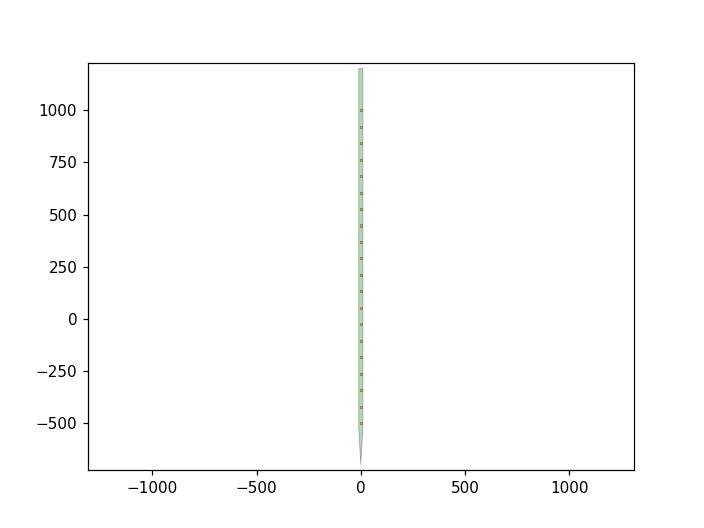

In [53]:
ax = mu.plot_probe(probe)
# nplt.plot_detailed_neuron(lfpy_cell, ax=ax, plane='xy', color_axon='blue', color_dend='r', color_apic='g', color_soma='k')

## Setup protocols, fitness, and evaluator

In [54]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

In [60]:
import l5pc_model
import l5pc_evaluator

feature_set = "extra" # 'soma'/'bap'

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()

l5pc_cell = ephys.models.LFPyCellModel('l5pc', 
                                       v_init=-65., 
                                       morph=morphology, 
                                       mechs=mechanisms, 
                                       params=parameters)

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

if feature_set == "extra":
    fitness_protocols = l5pc_evaluator.define_protocols(electrode) 
else:
    fitness_protocols = l5pc_evaluator.define_protocols() 
    
if feature_set == "extra":
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True, electrode=electrode)
else:
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True)

feature_file = l5pc_evaluator.compute_feature_values(release_params, l5pc_cell, fitness_protocols, sim, 
                                                     feature_set=feature_set, probe=probe, channels=None,
                                                     feature_folder='config/features')

fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols, feature_file=feature_file, 
                                                              probe=probe)

evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=l5pc_cell,                                                       
                param_names=param_names,                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim) 

Running bAP


/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150


In [61]:
for objective in fitness_calculator.objectives:
    print(objective.features[0].name)

Step3.soma.AP_height
Step3.soma.AHP_slow_time
Step3.soma.ISI_CV
Step3.soma.doublet_ISI
Step3.soma.adaptation_index2
Step3.soma.mean_frequency
Step3.soma.AHP_depth_abs_slow
Step3.soma.AP_width
Step3.soma.time_to_first_spike
Step3.soma.AHP_depth_abs
Step2.soma.AP_height
Step2.soma.AHP_slow_time
Step2.soma.ISI_CV
Step2.soma.doublet_ISI
Step2.soma.adaptation_index2
Step2.soma.mean_frequency
Step2.soma.AHP_depth_abs_slow
Step2.soma.AP_width
Step2.soma.time_to_first_spike
Step2.soma.AHP_depth_abs
Step1.soma.AP_height
Step1.soma.AHP_slow_time
Step1.soma.ISI_CV
Step1.soma.doublet_ISI
Step1.soma.adaptation_index2
Step1.soma.mean_frequency
Step1.soma.AHP_depth_abs_slow
Step1.soma.AP_width
Step1.soma.time_to_first_spike
Step1.soma.AHP_depth_abs
Step1.MEA.peak_to_valley_0
Step1.MEA.peak_to_valley_1
Step1.MEA.peak_to_valley_2
Step1.MEA.peak_to_valley_3
Step1.MEA.peak_to_valley_4
Step1.MEA.peak_to_valley_5
Step1.MEA.peak_to_valley_6
Step1.MEA.peak_to_valley_7
Step1.MEA.peak_to_valley_8
Step1.MEA.pea

In [62]:
t_start = time.time()
LFPy_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), 
                                         param_values=release_params)
t_end = time.time()
print(t_end-t_start)

/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib

24.7776780128479


In [ ]:
LFPy_responses

### Visualize waveforms / features

In [65]:
extrafeat = fitness_calculator.objectives[-1].features[0]

In [66]:
feat, mean_wf = extrafeat.calculate_feature(LFPy_responses, return_waveforms=True)

In [67]:
mean_wf.shape

(20, 2600)

In [68]:
tr, pk = bpopt.ephys.extra_features_utils._get_trough_and_peak_idx(mean_wf, False)

<IPython.core.display.Javascript object>


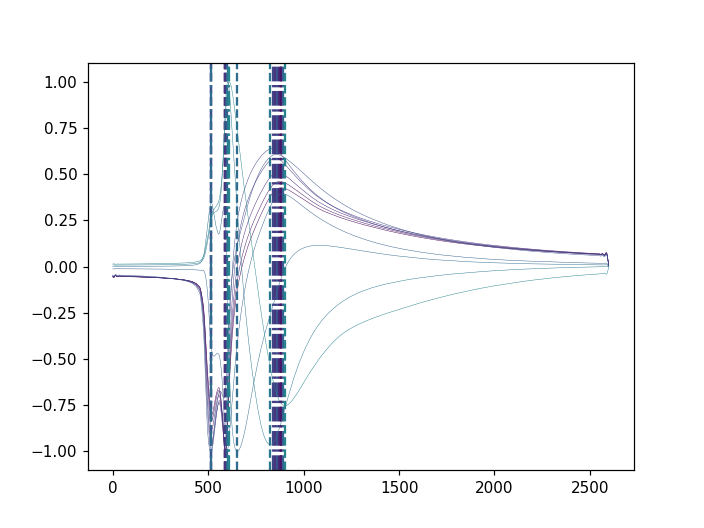

In [69]:
plt.figure()
cmap = plt.get_cmap('viridis')
idxs = range(0, 10)
for i, mw in enumerate(mean_wf):
    if i in idxs:
        color = cmap(i/len(mean_wf))
        plt.plot(mw / np.max(np.abs(mw)), color=color, lw=0.3)
        plt.axvline(tr[i], ls='--', color=color)
        plt.axvline(pk[i], ls='-.', color=color)

<IPython.core.display.Javascript object>


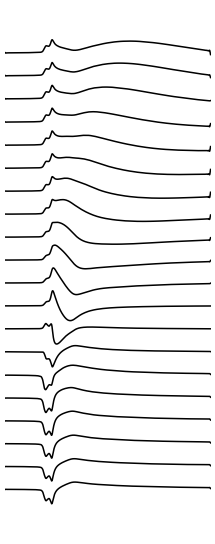

<IPython.core.display.Javascript object>


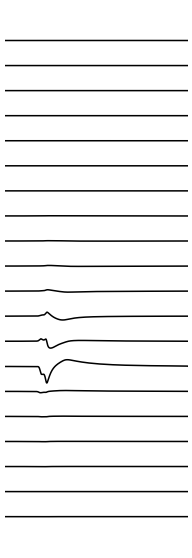

In [70]:
mean_wf_norm = mean_wf / np.max(np.abs(mean_wf), 1, keepdims=True)
mu.plot_mea_recording(mean_wf_norm, probe)

mu.plot_mea_recording(mean_wf, probe)

### TODO: make sure all values are correct

In [71]:
bpopt.ephys.extra_features_utils.calculate_features(mean_wf, extrafeat.fs * 1000, 
                                                    feature_names=['peak_to_valley', 'peak_trough_ratio', 'halfwidth',
                                                                   'neg_peak_relative', 'pos_peak_relative', 
                                                                   'neg_peak_diff', 'pos_peak_diff'])

{'peak_to_valley': array([ 0.01445,  0.0145 ,  0.014  ,  0.01305,  0.0162 ,  0.0174 ,
         0.01455, -0.0068 , -0.0111 , -0.01445, -0.0195 , -0.0365 ,
        -0.057  , -0.0691 , -0.09945, -0.09945, -0.0995 , -0.09955,
        -0.1002 , -0.1002 ]),
 'peak_trough_ratio': array([ -0.42697094,  -0.46125455,  -0.51010603,  -0.58711374,
         -0.63847599,  -0.60719983,  -0.39436322,  -0.34618668,
         -1.0391021 ,  -1.32912531,  -1.80182054,  -2.28005686,
         -2.27741566,  -2.41095907,  -2.64096368,  -2.98924191,
         -4.57402735, -48.73551865,  77.24175354,  48.91097593]),
 'halfwidth': array([ 0.0063 ,  0.00625,  0.00625,  0.00625,  0.00605,  0.00595,
         0.00415, -0.01195, -0.01445, -0.01985, -0.0286 , -0.04935,
        -0.0749 , -0.09195, -0.12935, -0.13645, -0.1477 , -0.167  ,
        -0.18345, -0.18935]),
 'neg_peak_diff': array([-0.0004 , -0.00045, -0.00045, -0.0005 , -0.00415, -0.00435,
         0.     ,  0.00265,  0.01125,  0.01505,  0.02105,  0.03955,
     

<IPython.core.display.Javascript object>


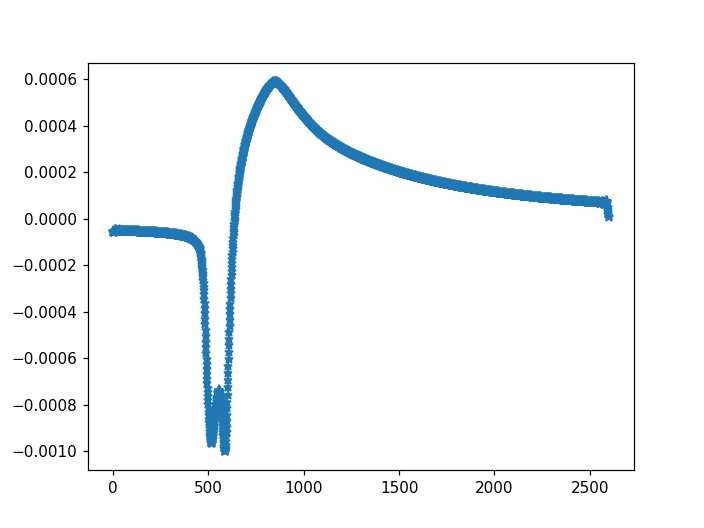

In [72]:
wf = mean_wf[3]
plt.figure()
plt.plot(wf, '*')

In [73]:
def plot_responses(responses):
    resp_no_mea = {}
    for (resp_name, response) in sorted(responses.items()):
        if 'MEA' not in resp_name:
            resp_no_mea[resp_name] = response
        else:
            print(resp_name)
    fig, axes = plt.subplots(len(resp_no_mea), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(resp_no_mea.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()

Step1.MEA.LFP
Step2.MEA.LFP
Step3.MEA.LFP
bAP.MEA.LFP


<IPython.core.display.Javascript object>


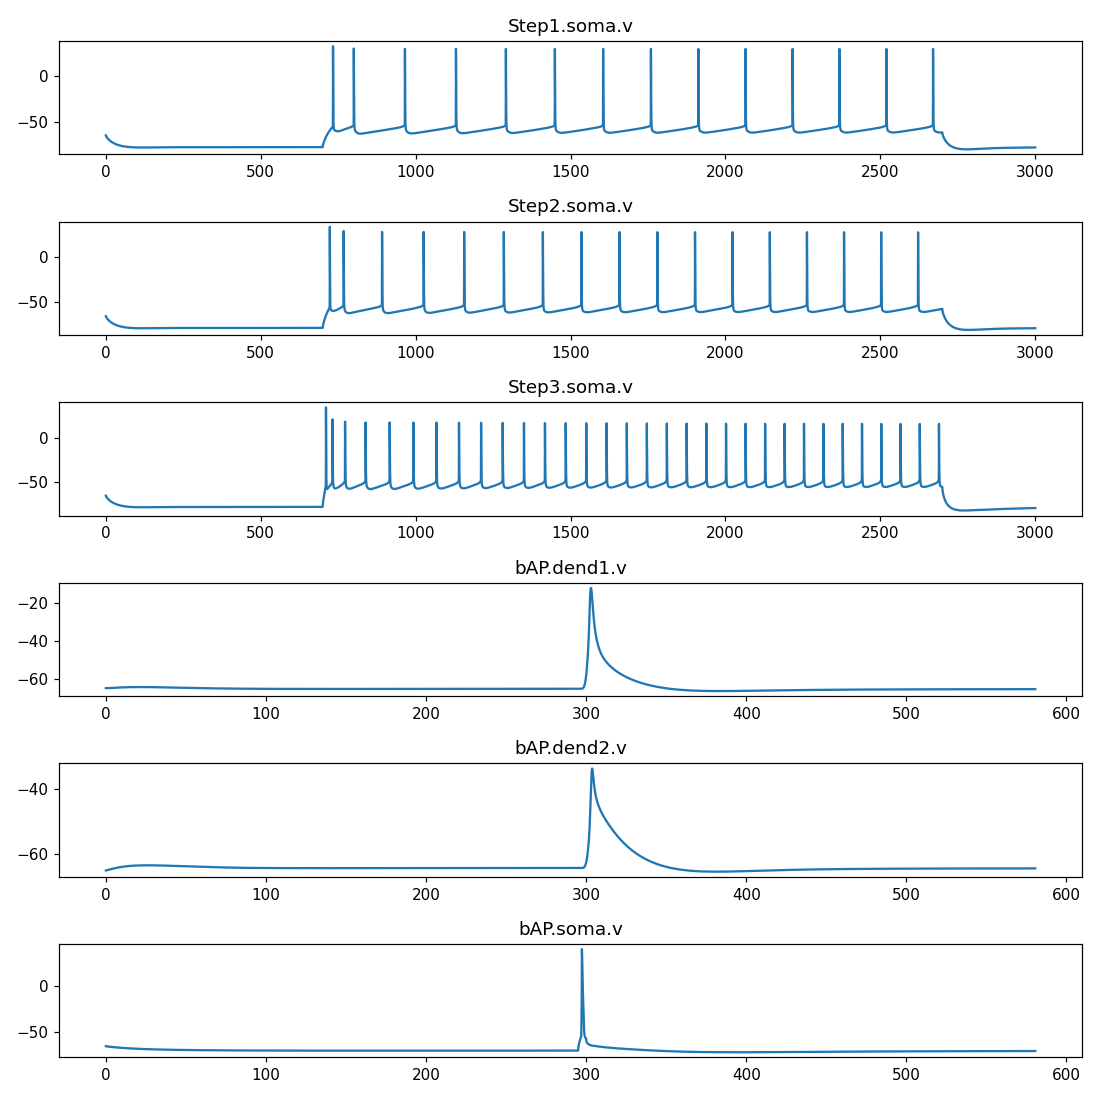

In [74]:
plot_responses(LFPy_responses)

<IPython.core.display.Javascript object>


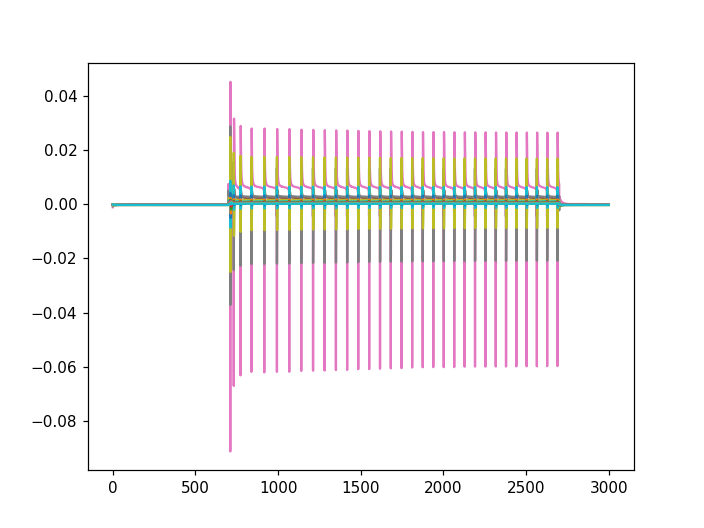

In [75]:
# plot one MEA response
plt.figure()
mea_response = LFPy_responses['Step3.MEA.LFP']
_ = plt.plot(mea_response['time'], mea_response['voltage'].T)

## Optimization

In [76]:
offspring_size = 250
max_ngen = 100

In [78]:
import multiprocessing

pool = multiprocessing.Pool(processes=4)

map_function = pool.map

In [79]:
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=offspring_size,
    map_function=map_function) 

In [81]:
t_start = time.time()
final_pop, halloffame, log, hist = opt.run(max_ngen=max_ngen, cp_filename='checkpoints/checkpoint_extra.pkl')
t_stop = time.time()
print('Optimization time', t_stop - t_start)

AssertionError: daemonic processes are not allowed to have children

In [ ]:
best_params = evaluator.param_dict(halloffame[0])
print(pp.pprint(best_params))
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

In [ ]:
plot_responses(best_responses)